In [7]:
import pandas
import numpy as np
import glob
import os
import matplotlib.pyplot as plt 

In [8]:
train_files = glob.glob('./../../hyperview1/train_data/train_data/train_data/*.npz')
test_files = glob.glob('./../../hyperview1/test_data/*.npz')


# sort files to ensure consistent order
train_files.sort()
test_files.sort()

In [9]:
# # rename the files to because they are not in order tranform 1.npz to 00001.npz


# for i, f in enumerate(train_files):
#     base = os.path.basename(f)
#     base_idx = int(base.split('.')[0])
#     new_name = f"{base_idx:05d}.npz"
#     os.rename(f, os.path.join(os.path.dirname(f), new_name))

# for i, f in enumerate(test_files):
#     base = os.path.basename(f)
#     base_idx = int(base.split('.')[0])
#     new_name = f"{base_idx:05d}.npz"
#     os.rename(f, os.path.join(os.path.dirname(f), new_name))

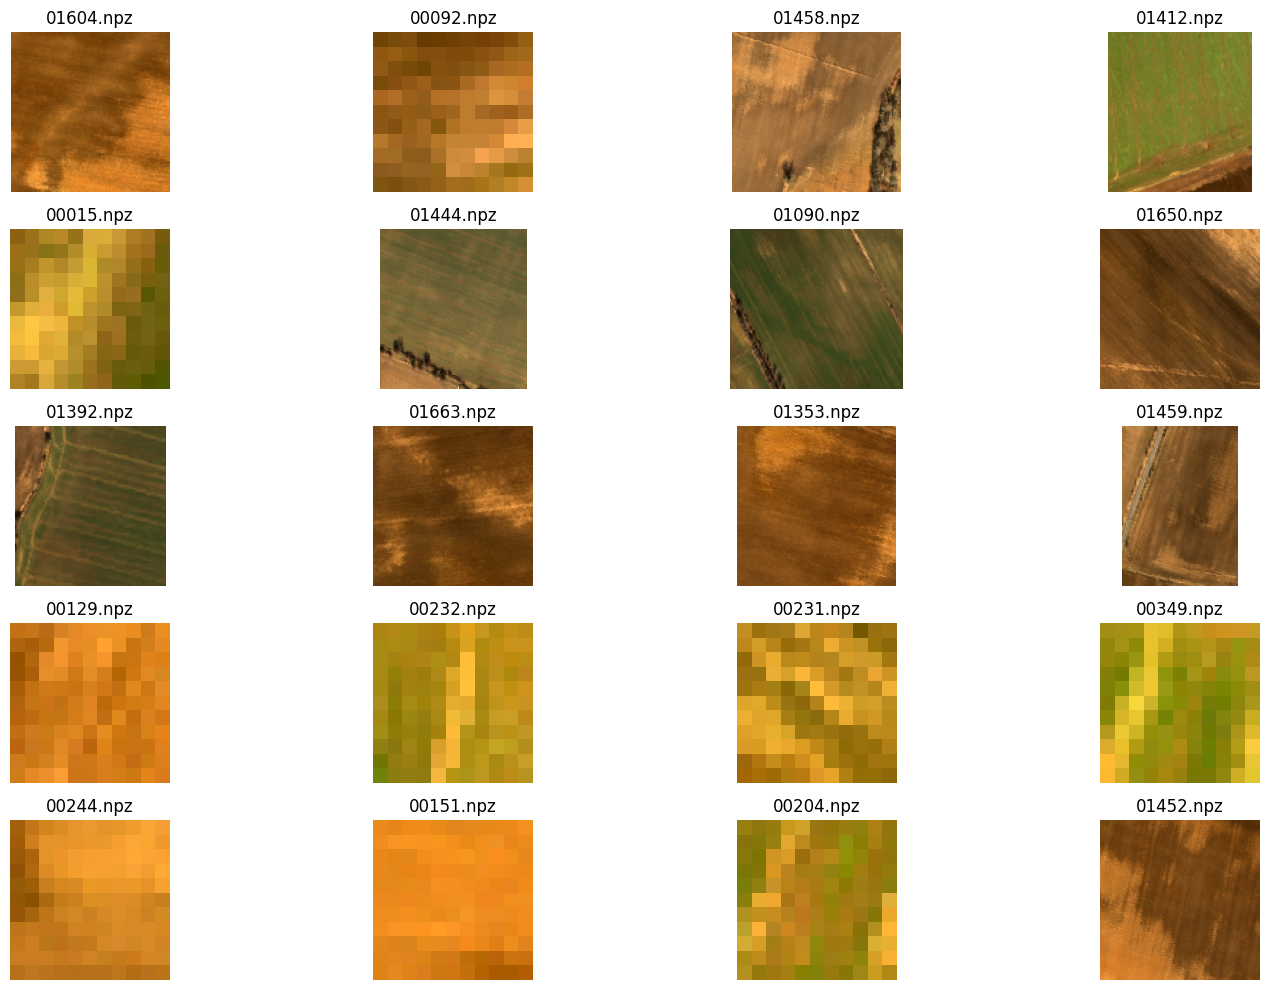

In [10]:
# Índices das bandas para RGB (Python usa índice zero)
rgb_indices = [58, 28, 2]  # R: 650.67nm, G: 554.78nm, B: 471.67nm

# Seleciona 20 arquivos aleatórios
random_files = np.random.choice(train_files, 20, replace=False)

plt.figure(figsize=(16, 10))
for i, f in enumerate(random_files):
    data = np.load(f)
    images = data['data']
    # Seleciona a primeira imagem do arquivo (ou ajuste se quiser outra)
    rgb_img = np.stack([
        images[rgb_indices[0], :, :],  # R
        images[rgb_indices[1], :, :],  # G
        images[rgb_indices[2], :, :]   # B
    ], axis=-1)
    # Normaliza para 0-1
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    plt.subplot(5, 4, i + 1)
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title(f.split('/')[-1])  # mostra nome do arquivo
plt.tight_layout()
plt.show()

In [11]:
np.load(train_files[674])['data'].shape  # Exemplo de carregamento de um arquivo

(150, 35, 38)

In [12]:
# quero fazer analise dos shapes 

h_train = []
w_train = []
n_pixels_train = []

for f in train_files:
    data = np.load(f)
    h_train.append(data['data'].shape[1])
    w_train.append(data['data'].shape[2])
    n_pixels_train.append(data['data'].shape[1] * data['data'].shape[2])
    

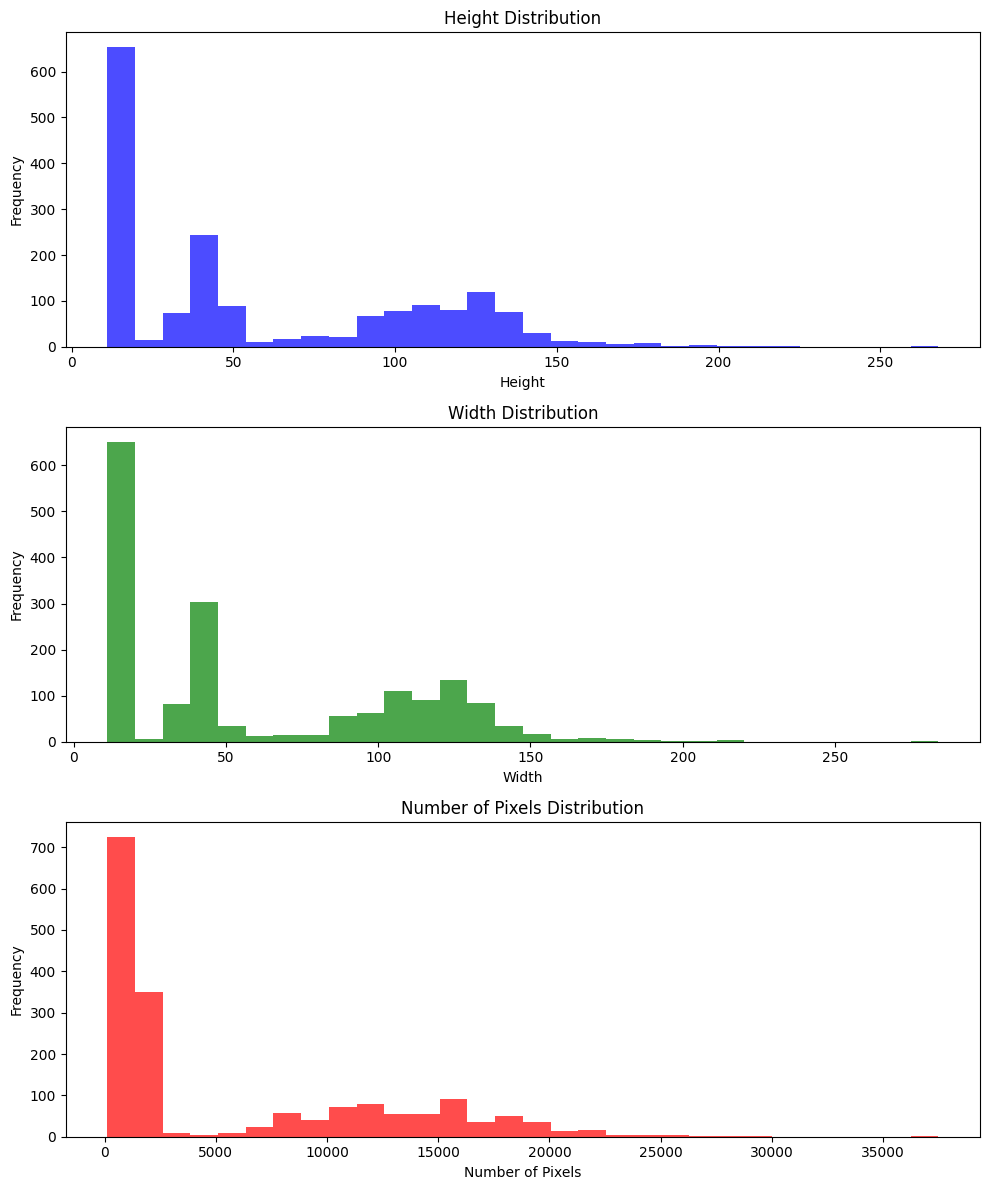

In [13]:
plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.hist(h_train, bins=30, color='blue', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(w_train, bins=30, color='green', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(n_pixels_train, bins=30, color='red', alpha=0.7)
plt.title('Number of Pixels Distribution')
plt.xlabel('Number of Pixels')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# quero fazer analise dos shapes 

h_test = []
w_test = []
n_pixels_test = []

for f in test_files:
    data = np.load(f)
    h_test.append(data['data'].shape[1])
    w_test.append(data['data'].shape[2])
    n_pixels_test.append(data['data'].shape[1] * data['data'].shape[2])

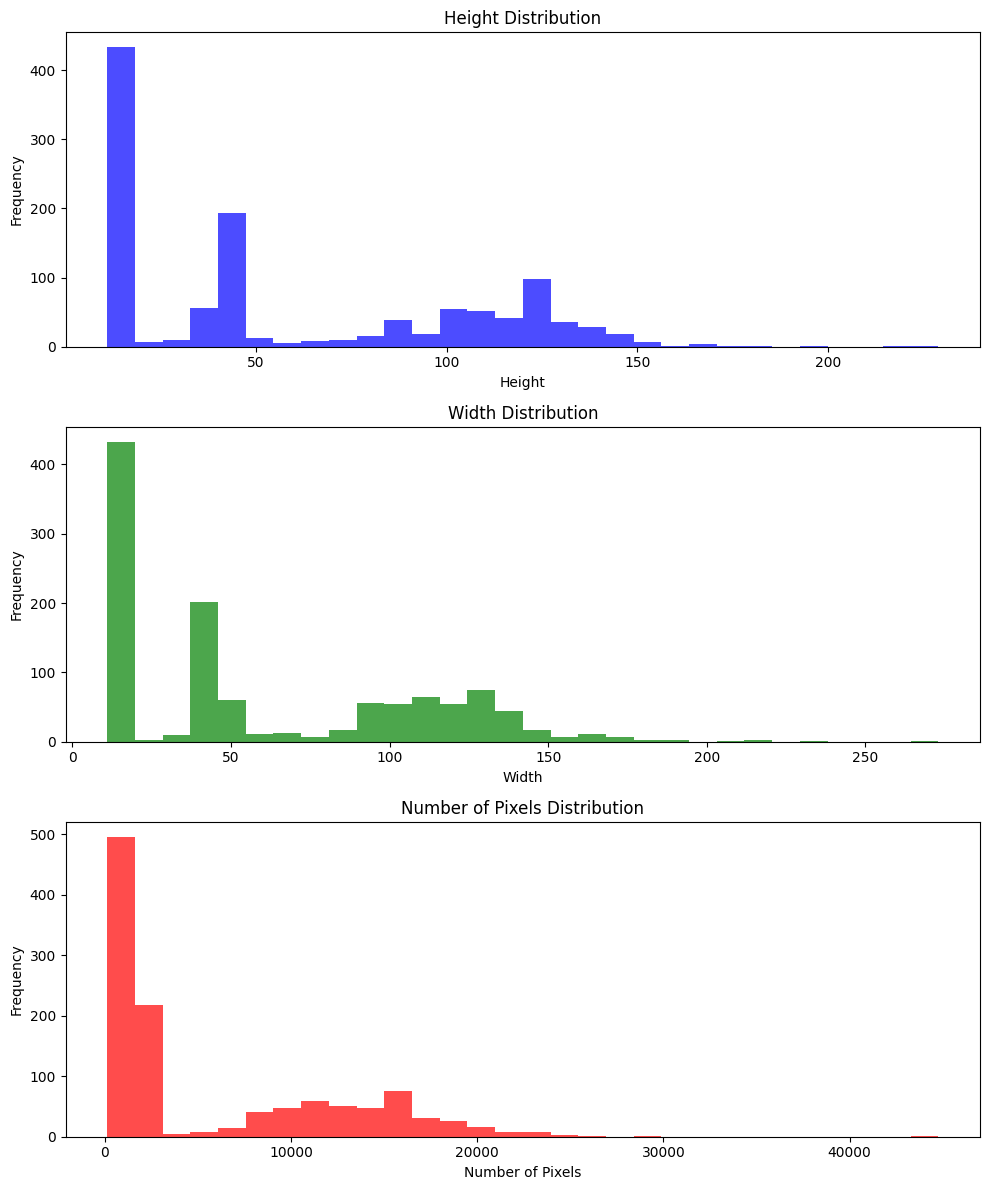

In [15]:
# plotar histogramas, subplots

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.hist(h_test, bins=30, color='blue', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency') 

plt.subplot(3, 1, 2)
plt.hist(w_test, bins=30, color='green', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(n_pixels_test, bins=30, color='red', alpha=0.7)
plt.title('Number of Pixels Distribution')
plt.xlabel('Number of Pixels')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:

n_bands = 150
all_means = []
all_stds = []
all_pixels = []

for f in train_files+test_files:
    data = np.load(f)['data']  # shape: (150, H, W)
    means = np.mean(data, axis=(1,2))  # média de cada banda
    stds = np.std(data, axis=(1,2))    # desvio padrão de cada banda
    pixels = data.shape[1] * data.shape[2]  # total de pixels por banda (igual para todas as bandas do arquivo)
    all_means.append(means)
    all_stds.append(stds)
    all_pixels.append(pixels)

all_means = np.array(all_means)  # shape: (n_files, 150)
all_stds = np.array(all_stds)    # shape: (n_files, 150)
all_pixels = np.array(all_pixels)  # shape: (n_files,)

# Para calcular a média ponderada de cada banda:
weighted_mean = np.average(all_means, axis=0, weights=all_pixels)
weighted_std = np.average(all_stds, axis=0, weights=all_pixels)

In [17]:
normalized_train = []
normalized_test = []

for f in train_files:
    data = np.load(f)['data']  # shape: (150, H, W)
    norm_data = (data - weighted_mean[:, None, None]) / weighted_std[:, None, None]
    normalized_train.append(norm_data)

for f in test_files:
    data = np.load(f)['data']  # shape: (150, H, W)
    norm_data = (data - weighted_mean[:, None, None]) / weighted_std[:, None, None]
    normalized_test.append(norm_data)

In [18]:
# tranformar train e test em um flatten, calcular o percentil 1 e 99 e fazer clip

flat_train = np.concatenate([img.reshape(n_bands, -1) for img in normalized_train], axis=1)  # shape: (150, total_pixels)
flat_test = np.concatenate([img.reshape(n_bands, -1) for img in normalized_test], axis=1)    # shape: (150, total_pixels)
p1 = np.percentile(flat_train, 1, axis=1)  # shape: (150,)
p99 = np.percentile(flat_train, 99, axis=1)  # shape: (150,)
normalized_train = [(np.clip(img, p1[:, None, None], p99[:, None, None])) for img in normalized_train]
normalized_test = [(np.clip(img, p1[:, None, None], p99[:, None, None])) for img in normalized_test]


# del  flat_train, flat_test  # liberar memória

del flat_train, flat_test  # liberar memória

In [19]:
#printar o max e o min e o index da imagem
for i in range(len(normalized_train)):
    print(np.min(normalized_train[i]), np.max(normalized_train[i]), i)

-1.2193935082157643 2.721581943416875 0
0.5243123760522014 4.353253822546011 1
-1.95196386662728 2.1370543769873134 2
-0.5959033881771943 4.474877116365925 3
-1.2174574125782893 3.3961328999657656 4
-0.938653656331454 3.9645585222292934 5
-1.7561149911210263 3.689222635863851 6
-1.546824649547234 4.474877116365925 7
-0.3300528799229817 2.872183697981512 8
-1.1812056756915508 4.474877116365925 9
-1.2743372508514166 3.3527561151565046 10
-0.7732884009710226 6.042170284466555 11
-1.8736156258783947 2.009176471177908 12
0.40696912646888 5.512565161192777 13
-1.9873683064504388 4.108993899060695 14
-1.351421689294554 4.331739397276143 15
-2.3406719826481526 6.397998960524104 16
-0.4080621889284009 6.083142922237098 17
-1.1880821858129933 3.4700398132044175 18
-1.4098819182552995 1.82156802837947 19
-0.6013480606191883 4.172388805167297 20
0.3333836165299934 4.406706466898692 21
-1.6483174676385457 3.582071876250773 22
-0.48422175680925683 3.4637876497598947 23
-1.9046784639464767 4.00153283

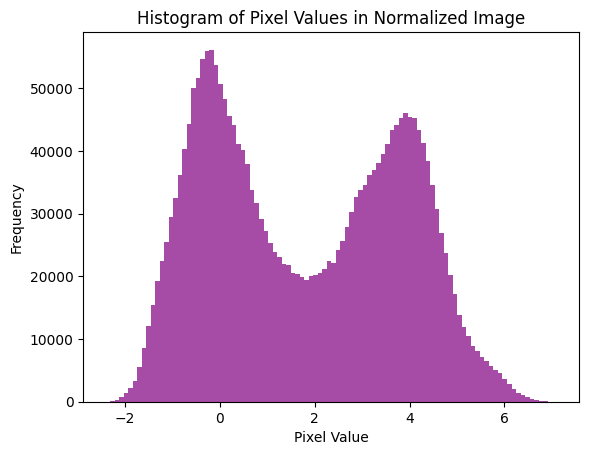

In [31]:
# pegar uma imagem e plotar o histograma  dos valores dos pixes


img = normalized_train[1443].flatten()

plt.hist(img, bins=100, color='purple', alpha=0.7)
plt.title('Histogram of Pixel Values in Normalized Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [27]:
# save normalized images as npy files in a folder
normalized_npy = './../../hyperview1/normalized_w_o_patches_npy/'
os.makedirs(normalized_npy, exist_ok=True)

# train and test folder
train_folder = os.path.join(normalized_npy, 'train')
test_folder = os.path.join(normalized_npy, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# save train images in a folder train

for i, img in enumerate(normalized_train):
    np.save(os.path.join(train_folder, f'train_{i:05d}.npy'), img)

for i, img in enumerate(normalized_test):
    np.save(os.path.join(test_folder, f'test_{i:05d}.npy'), img)

In [28]:
normalized_npy = './../../hyperview1/normalized_w_o_patches_npy/'

normalized_files = glob.glob(normalized_npy + '**/*.npy')

In [29]:
len(normalized_files)

2886